In [102]:
#Import Data and Libraries
import time
import math
import scipy
import scipy.io
import scipy.signal as s
import scipy.integrate as integrate
import scipy.interpolate as interp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x,peak):
    total = sum(x)
    for i in range(1,peak):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
#   t90(x,peak) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of time

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

#f1 = test['Data1']

#f1 = f1*(10**6) #convert to micro pascals
fs = 250


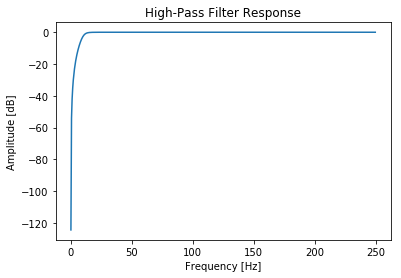

In [103]:
# I. High Pass Filter to remove streamer noise

#Applies 5th order high pass butterworth filter with 11hz cutoff to remove streamer noise

b,a = s.butter(4,Wn=11/fs,btype='highpass')#check this!
w,h = s.freqz(b,a)

fig = plt.figure()
plt.title('High-Pass Filter Response')

plt.plot(w*fs/(math.pi),todB(h))
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.show()

fData = []
for column in f1.T:
    fData.append(s.filtfilt(b,a,column))
fData = np.transpose(fData)

In [104]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data
fData = fData*(10**6) 

In [105]:
# III. Windowing Around Peak (2s before and after)

winData = []#windowed data
peak = []
for column in fData.T:
    peak1 = np.argmax(column[3000:4500])+3000 #look for peak near 15s
    #print(peak1)
    PRE = np.zeros(peak1-2*fs-1)#add zeros before
    DATA = column[peak1-2*fs:peak1+2*fs]#Keep data around the peak
    POST = np.zeros(len(column)-(peak1+2*fs)+1)#add zeros after
    k = np.concatenate((PRE,DATA,POST),axis=0)#creates windowed channel
    winData.append(k)
    peak.append(peak1)
winData = np.transpose(winData)
print(len(winData))

11264


In [106]:
# IV. Calculate RMS Density

squaredPressure = winData**2
RMS = []
T90 = []
i = 0

for column in squaredPressure.T:
    T90a=t90(column,peak[i])
    #print(i)
    #RMS.append(scipy.integrate.simps(column,dx=1/fs)/T90a)#,even='avg'
    RMS.append(sum(column)/((T90a)*fs))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = 10*np.log10(RMS)#convert to dB
print(RMS)
#print(T90) 

[ 160.42835463  160.49510976  160.32960706  160.45136336  160.14787554
  159.84344337  160.22531711  159.92591173  159.93833344  160.00397745
  160.50541217  160.89193611  160.24618248  160.67824204  160.66958262
  160.46944922  159.01796456  160.18079238  160.1793612   160.36284971
  160.79114645  161.08554385  161.17424215  161.07823227  161.4979839
  159.36000768  159.44856039  160.06919492  159.94092288  161.89012595
  162.81647247  163.96977629  163.99845945  164.15036067  164.26716528
  164.49693361  164.79335438  165.02035778  165.06207874  164.77572192
  164.98832794  164.87684325  164.62326163  164.53806741  164.98311945
  164.77173291  164.76485437  164.91008637  164.62549903  164.65474028
  164.79591595  165.1302183   162.61471195  162.58253697  162.87595091
  165.05966548  162.38897095  165.26302866  164.12070323  161.43740177
  161.43530272  160.05568654  160.36452439  161.64495054  161.19676583
  162.02328516  162.32512175  162.27947883  164.87352109  165.10585639
  165.1

In [107]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for column in RMS.T:
    SEL.append(column+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1

print(SEL)

scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[163.70807086360821, 163.77482599787024, 163.64185486632994, 163.84388970038924, 163.55628103802465, 163.22003228120118, 163.61784345422356, 163.334317229947, 163.34673893362174, 163.33240012471526, 163.61871169114383, 163.59639519448592, 163.59071998806058, 164.00666471297052, 163.91652175550951, 163.71638835598196, 162.39455347262302, 163.52532989601076, 163.49160900633365, 163.4591513848967, 163.71370716308289, 163.73372207814842, 163.60958317286807, 163.22667075484358, 163.53918373005499, 163.31851143683394, 163.37904505382355, 163.88575974925354, 163.75748770864351, 163.61615525870656, 164.10046516132132, 163.96977628765404, 163.99845944893883, 164.18496599466704, 164.40396225293338, 164.53153893154112, 164.75847109985966, 164.9854745040694, 165.02719545941278, 164.74083863682688, 164.98832793651584, 164.87684325189008, 164.65786694805087, 164.57267273552452, 164.98311945075088, 164.80633822767271, 164.69480535485096, 164.80458455029739, 164.66010434792398, 164.72367735567099, 164

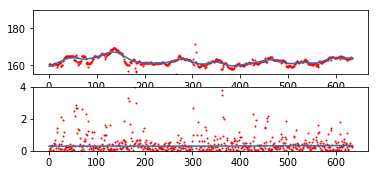

inaccurate: [61, 62, 81, 99, 160, 161, 162, 163, 164, 165, 166, 167, 168, 180, 182, 183, 264, 265, 303, 305, 308, 362, 376, 424, 505, 526, 596, 631] 
noisy: [25, 29, 52, 55, 56, 57, 59, 68, 78, 82, 100, 156, 181, 184, 266, 302, 304, 306, 309, 311, 360, 361, 364, 366, 377, 425, 427, 433, 456, 457, 458, 497, 506, 527, 597, 609, 632]


In [108]:
#V. Remove noisy or inaccurate channels
#RMS Differentials
noisy = []
inaccurate = []#keeps track of indicies
RMS2 = RMS.tolist() #without noisy and inaccurate channels
SEL2 = SEL#.tolist()
RMS_diff = [0]
r1 = 0
for r2 in range(1,636): #Uses relative difference to determine noisy channels
    RMS_diff.append(abs(RMS[r1]-RMS[r2]))
    r1 = r1+1
    
#local regression for RMS and RMS_diff
lowess = sm.nonparametric.lowess
b = np.linspace(0,635,636)
fit = lowess(RMS,b,is_sorted=True,return_sorted=False, frac=0.1)
fitd = lowess(RMS_diff,b,is_sorted=True,return_sorted=False,frac=1)


#Plots
plt.subplot(3,1,1)
plt.plot(b,fit)
plt.scatter(b,RMS,s=1,color='r')
plt.ylim(155,190)
plt.subplot(3,1,2)
plt.plot(b,fitd)
plt.scatter(b,RMS_diff,s=1,color='r')
plt.ylim(0,4)

#Remove bad channels

largeDelta = ((RMS2-fit)**2>=10)#innacurate
largeDelta2 = ((RMS_diff-fitd)**2>=2)#noisy

for i in range(0,636):
    if(largeDelta[i]):
        inaccurate.append(i)
        RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
    if(largeDelta2[i] and not(largeDelta[i])):
        noisy.append(i)
        RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        
        
        
        
        SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
plt.show()
print('inaccurate:',inaccurate,'\nnoisy:',noisy)


SEL180 = 12.4875
SEL160 = 12.4875
RMS180 = 12.037500000000001
RMS160 = 12.037500000000001


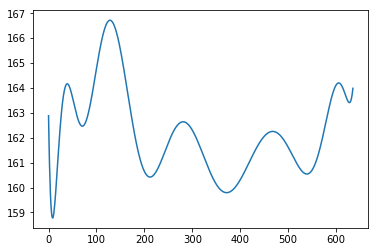

In [109]:
#VI. Fitting Data
#SELspl = interp.UnivariateSpline(SEL2,b)# callable type
#RMSspl = interp.UnivariateSpline(RMS2,b)
#print(b.shape,' ',RMS2.shape)
#for i in innacurate:
    
#SELpol = interp.interp1d(b,SEL2,kind='nearest',assume_sorted=True,fill_value='extrapolate')
#RMSpol = interp.interp1d(b,RMS2,kind='nearest',assume_sorted=True,fill_value='extrapolate')

SELmodel = np.polyfit(b, SEL2, deg=15)
RMSmodel = np.polyfit(b, RMS2, deg=15)

SELpol = np.poly1d(SELmodel) 
RMSpol = np.poly1d(RMSmodel)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    #print(SELpol(i))
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b,RMSpol(b))
plt.show()

In [110]:
#print(f1[1])
#plt.plot(np.linspace(0,636,636),f1[100])
#plt.show()


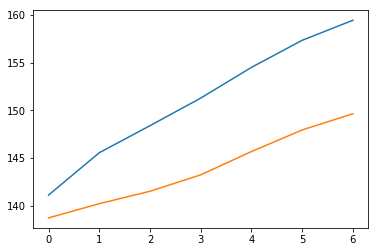

In [111]:
#Figure 3 replicated
#Very long computation
'''start = time.time()#timing
avgSEL=[]
avgRMS=[]
for T in range(1,8):#for each window size [1,8]
    winData = []
    peak = []
    for column in fData.T:#Window and square pressure around peaks
        peak1 = np.argmax(column[3000:4500])+3000 
        PRE = np.zeros(peak1-T*fs-1)
        DATA = column[peak1-T*fs:peak1+T*fs]
        POST = np.zeros(len(column)-(peak1+T*fs)+1)
        k = np.concatenate((PRE,DATA,POST),axis=0)#creates windowed channel
        winData.append(k)
        peak.append(peak1)
    winData = np.transpose(winData)
    squaredPressure = winData**2
    RMS = []
    T90 = []
    i = 0
    for column in squaredPressure.T:#compute RMS
        T90a=t90(column,peak[i])
        RMS.append(sum(column)/((T90a)*fs))
        i = i+1
        T90.append(T90a)
    RMS = 10*np.log10(RMS)
    SEL=[]
    i = 0
    for column in RMS.T:#compute SEL
        SEL.append(column+10*np.log10(T90[i]))
        i = i+1
    avgSEL.append(np.mean(SEL));
    avgRMS.append(np.mean(RMS));'''

#scipy.io.savemat('Data2.mat', mdict={'avgSEL':avgSEL,'avgRMS':avgRMS})#debug
rmsel = scipy.io.loadmat('Data2.mat')
avgSEL=rmsel['avgSEL']
avgRMS=rmsel['avgRMS']
plt.plot(avgSEL[0])
plt.plot(avgRMS[0])

plt.show()
#end = time.time()

#print('Time Elapsed (s)',end - start)




In [112]:
print(avgSEL)

[[ 141.09526894  145.54668155  148.38740032  151.28420122  154.51277263
   157.35460856  159.46134829]]


In [113]:
print(avgRMS)

[[ 138.6980336   140.19484423  141.49846608  143.22366347  145.67004875
   147.93762501  149.64342878]]
